In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import datetime
import numpy as np
import os
from acoustic_data_science import config, helpers
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import sklearn.decomposition
from sklearn.decomposition import PCA

In [6]:
df = pd.read_feather(path=helpers.feather_path_from_month_name(config.processed_data_path, '2018_09'))
df.head()

,25,32,40,50,63,79,100,126,158,200,...,12589,15849,19953,25119,filename,timestamp,broadband_spl,background_spl,loud,short_transient
0,75.693825,80.520737,85.266861,81.881416,82.047997,81.380539,80.367310,93.632103,87.657715,85.200058,...,77.848167,74.832794,71.063194,68.392067,ICLISTENHF1266_20180901T005601.000Z_TOL_1sHann...,2018-09-01 00:56:07.000,-44.413164,-63.098310,True,False
1,79.081276,78.940300,85.626244,82.353142,83.285545,80.016045,81.904541,94.733398,91.117569,85.514633,...,77.670433,75.122459,71.220116,68.304085,ICLISTENHF1266_20180901T005601.000Z_TOL_1sHann...,2018-09-01 00:56:07.500,-44.047909,-63.097328,True,False
2,79.300568,80.711739,82.846222,81.211761,85.413177,78.544655,80.360954,93.506638,89.608444,85.255714,...,77.645226,74.856186,70.915550,67.533752,ICLISTENHF1266_20180901T005601.000Z_TOL_1sHann...,2018-09-01 00:56:08.000,-44.424525,-63.096212,True,False
3,79.305504,76.850327,84.305954,81.466446,82.886604,79.373764,80.815041,96.889206,90.504097,83.300438,...,76.943581,74.129311,70.629143,67.287865,ICLISTENHF1266_20180901T005601.000Z_TOL_1sHann...,2018-09-01 00:56:08.500,-43.790167,-63.095055,True,False
4,75.861710,78.843033,85.188843,83.245949,83.154533,81.378975,78.326126,96.463661,90.205589,82.764427,...,76.922058,73.598251,70.131660,66.596886,ICLISTENHF1266_20180901T005601.000Z_TOL_1sHann...,2018-09-01 00:56:09.000,-44.161247,-63.094032,True,False


In [11]:
tols_df = helpers.get_tols_df(df)

In [18]:
# Scale the data.
scaler = StandardScaler()
scaler.fit(tols_df)
scaled_data = scaler.transform(tols_df)

# PCA.
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(scaled_data)
pca_components = pca.transform(scaled_data)

#principal components 
pc1 = pca_components[:,0]
pc2 = pca_components[:,1]
pc3 = pca_components[:,2]

In [36]:
#print the explained variance of each component
print(f'Explained variation per principal component:')
[print(f"PC{i} {component*100:.2f} %") for i, component in enumerate(pca.explained_variance_ratio_)]
print(f'Total explained variation: {sum(pca.explained_variance_ratio_)*100:.1f} %')

Explained variation per principal component:
PC0 78.65 %
PC1 12.68 %
PC2 2.51 %
Total explained variation: 93.8 %


In [38]:
colours = df['timestamp'].to_numpy()
colours = colours.astype(float)
colours

array([1.53576337e+18, 1.53576337e+18, 1.53576337e+18, ...,
       1.53835218e+18, 1.53835218e+18, 1.53835218e+18])

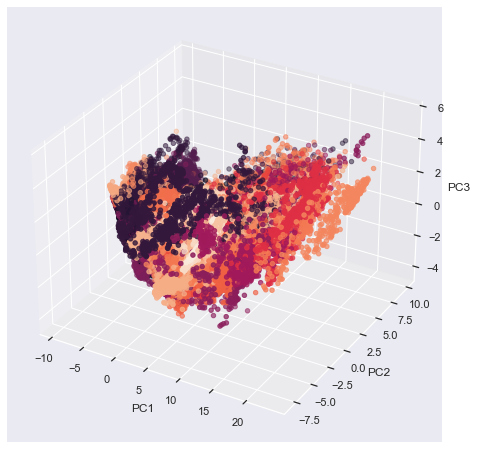

In [48]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
step = 10
ax.scatter(PC1[::step], PC2[::step], PC3[::step], c=colours[::step])
plt.show()

In [50]:
#create dataframe to show correlations of components to original frequencies to visualise PC's
df_feature_importance = pd.DataFrame(pca.components_).transpose()
df_feature_importance.rename(columns={0:'PC1', 1:'PC2', 2:'PC3'}, inplace=True)
df_feature_importance.head()

,PC1,PC2,PC3
0,0.134226,-0.131187,-0.013503
1,0.152598,-0.227655,0.109988
2,0.163593,-0.214309,0.253436
3,0.153444,-0.253203,0.281121
4,0.161577,-0.235388,0.275704


In [51]:
#create column of frequencies as type float and add to feature importance dataframe
freq = tols_df.columns.to_numpy()
freq = freq.astype(float)
df_feature_importance['Frequency'] = freq
df_feature_importance.set_index('Frequency', inplace=True)
df_feature_importance.head()

,PC1,PC2,PC3
Frequency,,,
25.0,0.134226,-0.131187,-0.013503
32.0,0.152598,-0.227655,0.109988
40.0,0.163593,-0.214309,0.253436
50.0,0.153444,-0.253203,0.281121
63.0,0.161577,-0.235388,0.275704


(0.0, 1000.0)

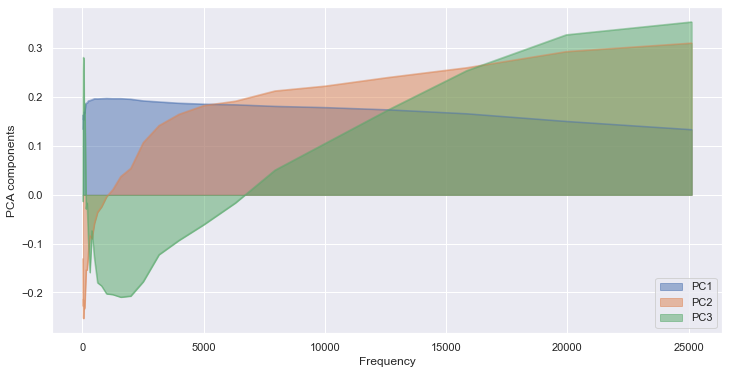

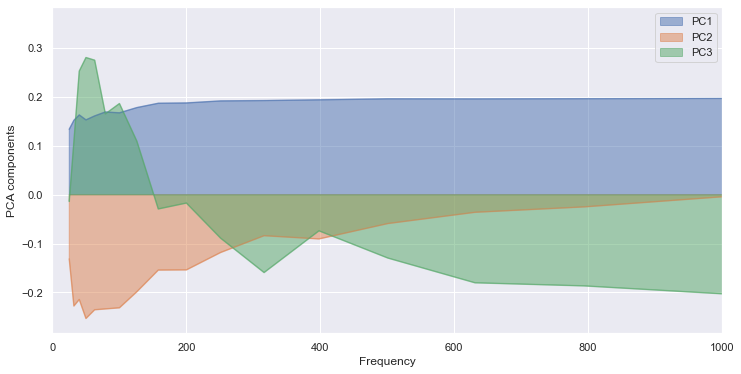

In [54]:
#plot feature importance against frequency for each principal component
df_feature_importance.plot.area(stacked=False, figsize=(12,6))
plt.xlabel('Frequency')
plt.ylabel('PCA components')

#plot feature importance against frequency under 1kHz for each principal component
df_feature_importance.plot.area(stacked=False, figsize=(12,6))
plt.xlabel('Frequency')
plt.ylabel('PCA components')
plt.xlim(0, 1000)